In [253]:
import asyncio
import websockets
import json
import pandas as pd
#import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()

import csv
from scipy import stats
import os

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
posn_path = os.path.join(os.getcwd(), "performance_analytics","positions.xlsx")
idx_path = os.path.join(os.getcwd(), "performance_analytics","eth_index.csv")
val_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\val.xlsx"

In [255]:
hdata = HistData('ETH')
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
eth_idx = hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']]
eth_idx.index = [dt.strftime('%Y-%m-%d') for dt in eth_idx.index]
eth_idx.index.names = ['Date']
eth_idx.to_csv(idx_path)
#eth_idx.to_csv(idx_path)

In [256]:
positions = pd.read_excel(posn_path,index_col = 0)
idx_px = pd.read_csv(idx_path,index_col = 0)
val = pd.read_excel(val_path,index_col = 0)

In [257]:
skeleton = pd.DataFrame()
indices = pd.date_range(datetime.datetime.fromtimestamp(start_dt/1000),pd.datetime.today())
indices = [dt.strftime("%Y-%m-%d") for dt in indices]
skeleton.index = indices

In [258]:
positions = pd.concat([skeleton,positions],axis = 1).fillna(method = 'ffill')
positions.to_excel(posn_path)

In [259]:
latest_val = val.iloc[-1][0]
#dep = int(input())
dep = latest_val
latest_val = pd.DataFrame([dep],index = [pd.datetime.today().date()],columns = ['val'])
#latest_val

In [260]:
start_dt = val.index[0]
skeleton = pd.DataFrame(index = pd.date_range(start_dt,pd.datetime.today()),columns = ['val'])
val = val.reindex_like(skeleton).fillna(method = 'ffill')
val.to_excel(val_path)

with open(val_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(latest_val)):
        temp = latest_val.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [261]:
val = pd.read_excel(val_path,index_col = 0)
val

,val
2024-01-01,3000
2024-01-02,3000
2024-01-03,3000
2024-01-04,3000
2024-01-05,3000
...,...
2024-04-03,3000
2024-04-04,3000
2024-04-05,3000
2024-04-06,3000


In [262]:
idx_px.index.names,positions.index.names = ['Date'],['Date']

In [263]:
usd_rets = positions.join(idx_px,on='Date',how = 'left')
usd_rets['Tactical Beta Convexity'] = usd_rets['close'].diff()*usd_rets['positions']

In [264]:
usd_rets = usd_rets.dropna()
usd_rets.dropna()

,positions,close,Tactical Beta Convexity
Date,,,
2024-01-02,0.80000,2363.35,-22.240000
2024-01-03,0.80000,2224.55,-111.040000
2024-01-04,0.80000,2255.15,24.480000
2024-01-05,0.80000,2233.35,-17.440000
2024-01-06,0.80000,2250.25,13.520000
...,...,...,...
2024-04-02,0.83152,3309.90,-55.462384
2024-04-03,0.83152,3321.05,9.271448
2024-04-04,0.83152,3285.95,-29.186352


In [265]:
vol_float_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\floating_rets.csv"
vol_rel_pnl_path = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility\\performance_analytics\\realized_rets.csv"

In [266]:
vol_float_rets = pd.read_csv(vol_float_pnl_path,index_col = 0)
vol_rel_rets = pd.read_csv(vol_rel_pnl_path,index_col = 0)
vol_rel_rets = vol_rel_rets.groupby(vol_rel_rets.index).sum()
vol_rel_rets = vol_rel_rets[['PnL','txn_cost']]
#vol_rel_rets = vol_rel_rets['PnL']-vol_rel_rets['txn_cost']

In [267]:

#vol_float_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_float_rets.index,format = "%d/%m/%Y")]
#vol_rel_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rel_rets.index,format = "%Y-%m-%d")]

In [268]:
vol_rets = pd.DataFrame(pd.concat([vol_float_rets,vol_rel_rets[['PnL']]],axis=1).sum(axis=1),columns = ['Short Volatility'])
vol_rets = pd.concat([vol_rets,vol_rel_rets[['txn_cost']]],axis=1)
vol_rets.columns  = ['Short Volatility','Txn Cost']
vol_rets.fillna(0,inplace = True)

In [269]:
curr_px = usd_rets['close'].iloc[-1]
vol_rets = vol_rets*curr_px

In [270]:
convexity = usd_rets[['Tactical Beta Convexity']]
convexity.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(convexity.index)]

In [271]:
vol_rets

,Short Volatility,Txn Cost
Date,,
2024-02-01,0.000000,0.0
2024-02-02,0.000000,0.0
2024-02-03,0.000000,0.0
2024-02-04,0.000000,0.0
2024-02-05,0.000000,0.0
...,...,...
2024-04-03,-26.887441,0.0
2024-04-04,39.669776,0.0
2024-04-05,0.000000,0.0


In [272]:
vol_rets.index = [dt.strftime('%Y-%m-%d') for dt in pd.to_datetime(vol_rets.index)]

In [273]:
vol_rets

,Short Volatility,Txn Cost
2024-02-01,0.000000,0.0
2024-02-02,0.000000,0.0
2024-02-03,0.000000,0.0
2024-02-04,0.000000,0.0
2024-02-05,0.000000,0.0
...,...,...
2024-04-03,-26.887441,0.0
2024-04-04,39.669776,0.0
2024-04-05,0.000000,0.0
2024-04-06,49.557047,0.0


In [274]:
usd_rets = pd.concat([convexity,vol_rets],axis=1).fillna(0)
usd_rets

,Tactical Beta Convexity,Short Volatility,Txn Cost
2024-01-02,-22.240000,0.000000,0.0
2024-01-03,-111.040000,0.000000,0.0
2024-01-04,24.480000,0.000000,0.0
2024-01-05,-17.440000,0.000000,0.0
2024-01-06,13.520000,0.000000,0.0
...,...,...,...
2024-04-03,9.271448,-26.887441,0.0
2024-04-04,-29.186352,39.669776,0.0
2024-04-05,32.304552,0.000000,0.0
2024-04-06,57.250152,49.557047,0.0


In [275]:

usd_rets['Total (Cost Adjusted)'] = usd_rets['Tactical Beta Convexity']+usd_rets['Short Volatility']-usd_rets['Txn Cost']
usd_rets.index.names = ["Date"]

<Axes: xlabel='Date'>

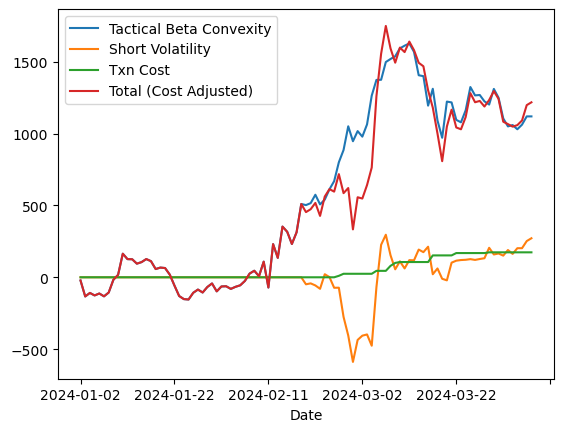

In [276]:
usd_rets.cumsum().plot()

In [277]:
val.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(val.index)]
vals = pd.concat([usd_rets,val],axis=1)['val']

In [278]:
usd_rets = pd.concat([usd_rets.cumsum(),val],axis=1).dropna()

In [279]:
for col in usd_rets.columns:
    usd_rets[col]=usd_rets[col]+usd_rets['val']



In [280]:
usd_rets.index = pd.to_datetime(usd_rets.index)

In [281]:
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Txn Cost']]

In [282]:
eth_idx.index = pd.to_datetime(eth_idx.index)

In [283]:
usd_rets = pd.concat([usd_rets,eth_idx],axis=1).fillna(method = 'ffill')

In [284]:
usd_rets

,Total (Cost Adjusted),Short Volatility,Tactical Beta Convexity,Txn Cost,close
2023-12-31,NaN,NaN,NaN,NaN,2285.40
2024-01-01,NaN,NaN,NaN,NaN,2391.15
2024-01-02,2977.760000,3000.000000,2977.760000,3000.000000,2363.35
2024-01-03,2866.720000,3000.000000,2866.720000,3000.000000,2224.55
2024-01-04,2891.200000,3000.000000,2891.200000,3000.000000,2255.15
...,...,...,...,...,...
2024-04-03,4048.000754,3162.722572,4058.905800,3173.627618,3321.05
2024-04-04,4058.484178,3202.392348,4029.719448,3173.627618,3285.95
2024-04-05,4090.788730,3202.392348,4062.024000,3173.627618,3324.80
2024-04-06,4197.595929,3251.949395,4119.274152,3173.627618,3393.65


In [285]:
usd_rets.columns = ['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Cost','Index']

In [286]:
usd_rets = usd_rets[['Total (Cost Adjusted)','Short Volatility','Tactical Beta Convexity','Index']]

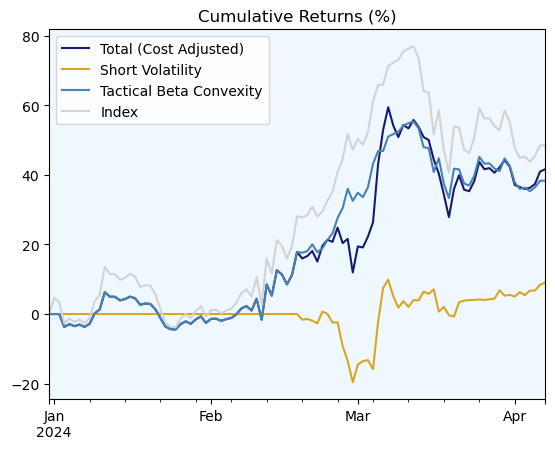

In [287]:
plot = (((1+(usd_rets.pct_change()).fillna(0)).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)',color = ['midnightblue','goldenrod','steelblue','lightgrey'])
#(((1+eth_idx.pct_change()).cumprod()-1)*100).plot()
plot.set_facecolor('aliceblue')
picpath = "c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\MasterFundPerformance.png"
plot.get_figure().savefig(picpath)

In [288]:
rets = usd_rets[['Total (Cost Adjusted)']].pct_change().fillna(0)

In [289]:
np.sqrt(252)* rets.mean()/rets.std()

Total (Cost Adjusted)    2.031393
dtype: float64

<Axes: title={'center': 'Master Fund Expanding-Window Sharpe Ratio'}>

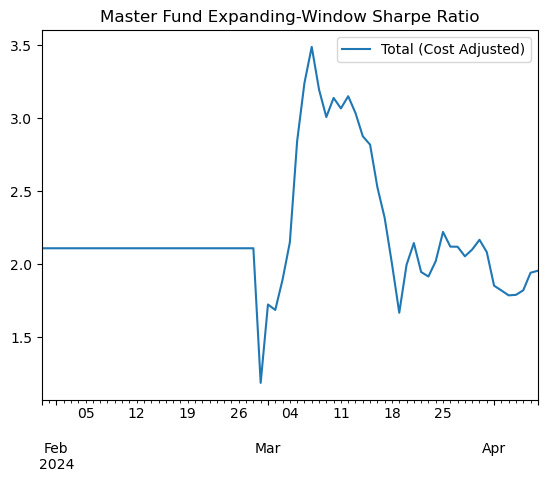

In [290]:
(np.sqrt(252)* (rets.expanding(60).mean()-0.053/350)/rets.expanding().std()).fillna(method = 'bfill')[30:].plot(title = 'Master Fund Expanding-Window Sharpe Ratio')